# Notebook 01 — Data QC & Controlled Splits (Pretrained-Model Prep)

This notebook performs **everything needed before loading a pretrained model**:
1. **Environment check**
2. **Scan `Segmented/`** for audio files and count per family/instrument
3. **Load or build a manifest**
4. **Validate** that manifest ↔ files align (missing/extra)
5. **YOU control the split** (fractions, random seed, grouping on/off, group key, stratify on/off)
6. **Save** `train.csv`, `val.csv`, `test.csv` to `Manifests/`

> The notebook respects your current project structure (`Segmented/`, `Manifests/`, `Results/`, etc.).

In [1]:
# --- 0) Imports ---
import os, sys, glob
from pathlib import Path
import pandas as pd
import numpy as np
import soundfile as sf

from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

print({
    "python": sys.version.split()[0],
    "pandas": pd.__version__,
    "numpy": np.__version__,
})

{'python': '3.10.19', 'pandas': '2.3.3', 'numpy': '2.2.5'}


In [3]:
# --- 1) Paths ---
base_dir = Path("..").resolve()
segmented_dir = base_dir / "Segmented"
manifests_dir = base_dir / "Manifests"

print("Base dir:", base_dir)
print("Segmented dir:", segmented_dir, "(exists:", segmented_dir.exists(), ")")
print("Manifests dir:", manifests_dir, "(exists:", manifests_dir.exists(), ")")

Base dir: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154
Segmented dir: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Segmented (exists: True )
Manifests dir: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests (exists: True )


## 2) Scan segmented data — counts & quick QC

In [4]:
# Recursively find audio files under Segmented/
audio_exts = {'.wav', '.flac', '.mp3', '.m4a'}
seg_files = [p for p in segmented_dir.rglob("*") if p.suffix.lower() in audio_exts]

print(f"Found {len(seg_files)} segmented audio files.")
# Infer family/instrument from directory layout Segmented/<family>/<instrument>/<file>.wav
def infer_family_instrument(path: Path):
    parts = path.relative_to(segmented_dir).parts
    fam = parts[0] if len(parts) >= 1 else None
    instr = parts[1] if len(parts) >= 2 else None
    return (fam, instr)

# Build a small dataframe for summary
seg_df = pd.DataFrame({
    "filepath": [str(p) for p in seg_files],
    "family_guess": [infer_family_instrument(p)[0] for p in seg_files],
    "instrument_guess": [infer_family_instrument(p)[1] for p in seg_files],
})
print("Top-level family counts (guessed from folders):")
display(seg_df['family_guess'].value_counts().sort_index())

print("Instrument counts (top 10):")
display(seg_df['instrument_guess'].value_counts().sort_index().head(10))

# Light accessibility check: try opening a few files
sample_paths = seg_files[:10]
ok, bad = 0, 0
for p in sample_paths:
    try:
        info = sf.info(str(p))
        ok += 1
    except Exception as e:
        bad += 1
print(f"Sampled {len(sample_paths)} files → readable: {ok}, errors: {bad}")

Found 874 segmented audio files.
Top-level family counts (guessed from folders):


family_guess
keyboards     214
percussion    143
strings       142
voice         170
winds         205
Name: count, dtype: int64

Instrument counts (top 10):


instrument_guess
bass            50
cello           22
clarinet        50
conga            9
cymbal           6
drum           110
flute           63
guitar          30
harpsichord     99
hum             52
Name: count, dtype: int64

Sampled 10 files → readable: 10, errors: 0


## 3) Load or build a manifest

In [6]:
# === Consolidate all CSV manifests into Manifests/manifest_master.csv ===
# Works with columns like: filepath_rel, family, Instrument, family_id, Instrument_id, source_file,
# clip_index, duration_s, rms_db, fs, cap_used (as in your screenshot)

from pathlib import Path
import pandas as pd, numpy as np

AUDIO_EXTS = {".wav", ".flac", ".mp3", ".m4a", ".ogg", ".aiff", ".aif"}

def make_abs_path(rel: str) -> str:
    """Build an absolute path from a manifest's relative path."""
    p = Path(rel)
    # If the path already starts with 'Segmented', anchor it at the project root (one level above Segmented)
    if len(p.parts) and p.parts[0].lower() == "segmented":
        return str((segmented_dir.parent / p).resolve())
    # Otherwise, interpret it as relative to Segmented/
    return str((segmented_dir / p).resolve())

csv_paths = sorted(manifests_dir.glob("*.csv"))
assert csv_paths, f"No CSVs found in {manifests_dir}"

rows = []
for p in csv_paths:
    try:
        df_i = pd.read_csv(p)
        df_i["_source_csv"]   = p.name
        df_i["_source_mtime"] = p.stat().st_mtime
        rows.append(df_i)
    except Exception as e:
        print(f"Skipping {p.name}: {e}")

assert rows, "Could not read any of the CSV manifests."
full = pd.concat(rows, ignore_index=True)

# --- Normalize/rename columns to a common schema ---
# filepath
if "filepath" not in full.columns:
    if "filepath_rel" in full.columns:
        full["filepath"] = full["filepath_rel"].astype(str).map(make_abs_path)
    elif "path" in full.columns:
        full["filepath"] = full["path"].astype(str).map(make_abs_path)
    else:
        raise AssertionError("No filepath or filepath_rel column found; cannot consolidate.")

# family label
if "family_label" not in full.columns:
    if "family" in full.columns:
        full["family_label"] = full["family"].astype(str)
    elif "label" in full.columns:
        full["family_label"] = full["label"].astype(str)
    else:
        # allow unlabeled flows (you can fill later), but keep the column
        full["family_label"] = np.nan

# instrument label
if "instrument_label" not in full.columns:
    if "Instrument" in full.columns:
        full["instrument_label"] = full["Instrument"].astype(str)
    elif "instrument" in full.columns:
        full["instrument_label"] = full["instrument"].astype(str)
    else:
        full["instrument_label"] = np.nan

# normalize types/casing
full["family_label"]     = full["family_label"].astype(str).str.strip().str.lower().replace({"nan": np.nan})
full["instrument_label"] = full["instrument_label"].astype(str).str.strip().str.lower().replace({"nan": np.nan})

# ensure grouping key
if "source_file" not in full.columns or full["source_file"].isna().all():
    from pathlib import Path as P
    full["source_file"] = full["filepath"].astype(str).apply(
        lambda x: P(x).parent.name if len(P(x).parts) > 1 else P(x).name
    )

# optional: keep useful numeric metadata if present (duration_s, rms_db, fs, cap_used, ids, etc.)
# nothing to do here; they already exist and will flow through

# --- Deduplicate ---
# Prefer entries that have labels + newest CSV; then drop duplicates by absolute filepath
full["_has_family"]     = full["family_label"].notna().astype(int)
full["_has_instrument"] = full["instrument_label"].notna().astype(int)

before = len(full)
full = full.sort_values(
    by=["_has_family", "_has_instrument", "_source_mtime"],
    ascending=[True, True, True]
).drop_duplicates(subset=["filepath"], keep="last")
after = len(full)
print(f"Deduplicated by filepath: {before} -> {after} rows")

# --- Finalize & save master ---
drop_helpers = ["_source_csv", "_source_mtime", "_has_family", "_has_instrument"]
final_cols = [c for c in full.columns if c not in drop_helpers]

master_csv = manifests_dir / "manifest_master.csv"
full[final_cols].to_csv(master_csv, index=False)
print(f"Wrote master manifest: {master_csv} (rows: {len(full)})")

# --- Load master into df for downstream cells ---
df = pd.read_csv(master_csv)

# Quick health check: files exist?
missing = [p for p in df["filepath"].astype(str) if not Path(p).exists()]
print(f"Files referenced: {len(df)} | Missing on disk: {len(missing)}")
display(df.head(5))


Deduplicated by filepath: 2574 -> 874 rows
Wrote master manifest: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests/manifest_master.csv (rows: 874)
Files referenced: 874 | Missing on disk: 0


,filepath_rel,family,instrument,family_id,instrument_id,source_file,clip_index,duration_s,rms_db,fs,cap_used,filepath,family_label,instrument_label
0,Segmented/percussion/drum/percussion_drum_perc...,percussion,drum,2,6,percussion_drum_004,28,3,-37.536038,16000,32,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum
1,Segmented/percussion/drum/percussion_drum_perc...,percussion,drum,2,6,percussion_drum_004,29,3,-39.845277,16000,32,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum
2,Segmented/percussion/drum/percussion_drum_perc...,percussion,drum,2,6,percussion_drum_004,30,3,-36.102368,16000,32,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum
3,Segmented/percussion/drum/percussion_drum_perc...,percussion,drum,2,6,percussion_drum_004,31,3,-32.540497,16000,32,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum
4,Segmented/percussion/drum/percussion_drum_perc...,percussion,drum,2,6,percussion_drum_004,32,3,-26.772069,16000,32,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum


## 4) Manifest ↔ Files validation

In [ ]:
# --- Validate master manifest vs Segmented/ contents (simple) ---

from pathlib import Path
import pandas as pd
import numpy as np

# 0) CONFIG (only change if you want)
PROJECT_ROOT = Path("/Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154")
MANIFESTS = PROJECT_ROOT / "Manifests"
SEGMENTED = PROJECT_ROOT / "Segmented"
PREFER_MANIFEST_NAME = "manifest_master.csv"   # if present, use this; otherwise first *.csv

# Candidate path column names we will try in order:
PATH_COL_CANDIDATES = ["filepath", "filepath_rel", "path", "file_path", "fullpath", "full_path", "audio_path", "wav_path"]

AUDIO_EXTS = {".wav", ".flac", ".mp3", ".m4a", ".ogg", ".aiff", ".aif"}

# 1) Pick the manifest CSV
if (MANIFESTS / PREFER_MANIFEST_NAME).exists():
    manifest_csv = MANIFESTS / PREFER_MANIFEST_NAME
else:
    csvs = sorted(MANIFESTS.glob("*.csv"))
    assert csvs, f"No CSVs found in {MANIFESTS}"
    manifest_csv = csvs[0]

print("Using manifest:", manifest_csv)

# 2) Load manifest and pick path column
df = pd.read_csv(manifest_csv)
path_col = next((c for c in PATH_COL_CANDIDATES if c in df.columns), None)
assert path_col is not None, f"None of {PATH_COL_CANDIDATES} found in {manifest_csv.name}"

# 3) Normalize manifest paths to absolute
def to_abs(p: str) -> str:
    P = Path(str(p))
    if P.is_absolute():
        return str(P.resolve())
    # if it starts with 'Segmented', anchor to project root
    if len(P.parts) and P.parts[0].lower() == "segmented":
        return str((PROJECT_ROOT / P).resolve())
    # otherwise treat as relative to Segmented/
    return str((SEGMENTED / P).resolve())

df["_abs_path"] = df[path_col].astype(str).map(to_abs)

# 4) Collect all audio files actually on disk under Segmented/
disk_paths = {str(p.resolve()) for p in SEGMENTED.rglob("*") if p.suffix.lower() in AUDIO_EXTS}

# 5) Compare
manifest_paths = set(df["_abs_path"].tolist())
missing_on_disk = sorted(p for p in manifest_paths if p not in disk_paths)     # listed in manifest but not found
extra_on_disk   = sorted(p for p in disk_paths     if p not in manifest_paths)  # exists on disk but not in manifest

# 6) Report
print(f"Manifest rows: {len(df)}")
print(f"Segmented files on disk: {len(disk_paths)}")
print(f"Missing on disk (in manifest but not found): {len(missing_on_disk)}")
print(f"Extra on disk (found but not in manifest): {len(extra_on_disk)}")

# Show a few examples (if any)
if missing_on_disk:
    display(pd.DataFrame({"missing_on_disk": missing_on_disk}).head(5))
if extra_on_disk:
    display(pd.DataFrame({"extra_on_disk": extra_on_disk}).head(5))


Using manifest: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests/manifest_master.csv
Manifest rows: 874
Segmented files on disk: 874
Missing on disk (in manifest but not found): 0
Extra on disk (found but not in manifest): 0
Saved reports to Manifests/validation_missing_on_disk.csv and validation_extra_on_disk.csv


## 5) Split controls (YOU decide)

In [ ]:
# --- USER CONTROLS FOR SPLITTING ---
RANDOM_SEED = 42

# Fractions must sum to 1.0
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15

# Grouping & stratification
USE_GROUPING = True            # True = keep clips with same GROUP_KEY in the same split
USE_STRATIFY = False           # Optional: stratify by FAMILY_COLNAME (turn off if grouping is on)

# Sanity:
assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-6, "Splits must sum to 1.0"
labels = df[FAMILY_COLNAME].astype(str).values
groups = df[GROUP_KEY].astype(str).values
X = np.arange(len(df))
print("Label distribution (overall):")
display(df[FAMILY_COLNAME].value_counts().sort_index())

Label distribution (overall):


family_label
keyboards     214
percussion    143
strings       142
voice         170
winds         205
Name: count, dtype: int64

### 5A) Grouped split (leakage-safe, recommended)

In [11]:
# 5A) Grouped split (leakage-safe) — upgraded to group-STRATIFIED so every class appears in each split

if USE_GROUPING:
    from sklearn.model_selection import StratifiedShuffleSplit

    LABEL = FAMILY_COLNAME
    GROUP = GROUP_KEY
    assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-6

    # --- Build group-level table (one row per group with its label mode) ---
    grp = (df.groupby(GROUP)
             .agg(label_mode=(LABEL, lambda x: x.mode().iat[0] if len(x.mode()) else x.iloc[0]),
                  n_rows=(LABEL, "size"))
             .reset_index())

    # Helper to check if all families are present in a row-level split
    all_fams = set(df[LABEL].unique())
    def has_all_fams(split_df): 
        return all_fams.issubset(set(split_df[LABEL].unique()))

    # Warn if some family has <3 groups (then one split may miss it)
    grp_counts = grp["label_mode"].value_counts()
    few = grp_counts[grp_counts < 3]
    if len(few):
        print("⚠️ Some families have fewer than 3 distinct groups; full coverage may be impossible:")
        display(few.rename("num_groups"))

    # --- Try multiple seeds to find a valid split ---
    MAX_RETRIES = 200
    best = None
    for k in range(MAX_RETRIES):
        seed = RANDOM_SEED + k

        # First split (groups): train vs temp, stratified by group label
        sss1 = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_FRAC, random_state=seed)
        g_idx = np.arange(len(grp))
        y_g   = grp["label_mode"].values
        train_g_idx, temp_g_idx = next(sss1.split(g_idx, y_g))

        train_groups = set(grp.iloc[train_g_idx][GROUP])
        temp_grp     = grp.iloc[temp_g_idx].reset_index(drop=True)

        # Second split (groups): val vs test, stratified by group label
        sss2 = StratifiedShuffleSplit(
            n_splits=1,
            train_size=VAL_FRAC / (VAL_FRAC + TEST_FRAC),
            random_state=seed + 123
        )
        t_idx = np.arange(len(temp_grp))
        val_g_rel, test_g_rel = next(sss2.split(t_idx, temp_grp["label_mode"].values))
        val_groups  = set(temp_grp.iloc[val_g_rel][GROUP])
        test_groups = set(temp_grp.iloc[test_g_rel][GROUP])

        # Map back to rows
        train_df = df[df[GROUP].isin(train_groups)].copy()
        val_df   = df[df[GROUP].isin(val_groups)].copy()
        test_df  = df[df[GROUP].isin(test_groups)].copy()

        # Coverage check
        if has_all_fams(train_df) and has_all_fams(val_df) and has_all_fams(test_df):
            best = (train_df, val_df, test_df, seed)
            break

    if best is None:
        print(f"⚠️ Tried {MAX_RETRIES} seeds but couldn't include all families in every split.")
        # Fall back to last attempt variables still in scope (train_df, val_df, test_df)
    else:
        train_df, val_df, test_df, used_seed = best
        print(f"✅ Group-stratified split found (seed={used_seed}) with all families in each set.")
else:
    train_df = val_df = test_df = None


✅ Group-stratified split found (seed=42) with all families in each set.


### 5B) Stratified split (only if you disable grouping)

In [ ]:
if not USE_GROUPING and USE_STRATIFY:
    sss1 = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_FRAC, random_state=RANDOM_SEED)
    train_idx, temp_idx = next(sss1.split(X, labels))
    temp_labels = labels[temp_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, train_size=VAL_FRAC/(VAL_FRAC+TEST_FRAC), random_state=RANDOM_SEED+1)
    val_rel_idx, test_rel_idx = next(sss2.split(np.arange(len(temp_labels)), temp_labels))
    temp_df = df.iloc[temp_idx].reset_index(drop=True)
    val_df  = temp_df.iloc[val_rel_idx].copy()
    test_df = temp_df.iloc[test_rel_idx].copy()
    train_df = df.iloc[train_idx].copy()

## 6) Split summaries & save to Manifests/

In [12]:
# 6) Split summaries & save to Manifests/

def summarize(name, d):
    print(f"\n{name}: {len(d)} rows")
    if FAMILY_COLNAME in d.columns:
        display(d[FAMILY_COLNAME].value_counts().sort_index())
    else:
        print(f"⚠️ Warning: Column '{FAMILY_COLNAME}' not found in this split!")

# --- Sanity check ---
assert train_df is not None and val_df is not None and test_df is not None, \
    "Splitting did not run — check controls or missing variables."
assert len(train_df) + len(val_df) + len(test_df) == len(df), \
    "⚠️ Row count mismatch — check that all data was assigned to a split!"

# --- Show summaries ---
summarize("TRAIN", train_df)
summarize("VAL", val_df)
summarize("TEST", test_df)

# --- Save to Manifests/ ---
out_train = manifests_dir / "train.csv"
out_val   = manifests_dir / "val.csv"
out_test  = manifests_dir / "test.csv"

# overwrite protection: confirm saves
train_df.to_csv(out_train, index=False)
val_df.to_csv(out_val, index=False)
test_df.to_csv(out_test, index=False)

print("\n✅ Split manifests saved successfully:")
print("  •", out_train)
print("  •", out_val)
print("  •", out_test)
print(f"\nTotal: {len(df)} rows ({len(train_df)} train, {len(val_df)} val, {len(test_df)} test)")



TRAIN: 579 rows


family_label
keyboards     156
percussion     75
strings        63
voice         154
winds         131
Name: count, dtype: int64


VAL: 149 rows


family_label
keyboards     14
percussion    13
strings       63
voice          1
winds         58
Name: count, dtype: int64


TEST: 146 rows


family_label
keyboards     44
percussion    55
strings       16
voice         15
winds         16
Name: count, dtype: int64


✅ Split manifests saved successfully:
  • /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests/train.csv
  • /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests/val.csv
  • /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests/test.csv

Total: 874 rows (579 train, 149 val, 146 test)


🎯 Data distribution by Family and Subfamily (Instrument)

Family counts:


,count
family_label,
keyboards,214
percussion,143
strings,142
voice,170
winds,205



Subfamily (Family + Instrument) counts:


,family_label,instrument,count
6,percussion,drum,110
0,keyboards,harpsichord,99
15,voice,sing,78
18,winds,flute,63
2,keyboards,piano,61
14,voice,hum,52
9,strings,bass,50
17,winds,clarinet,50
21,winds,trumpet,44
16,voice,spoken,40


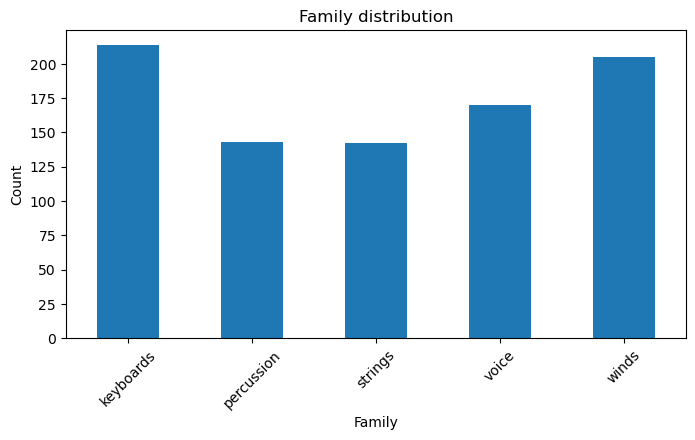

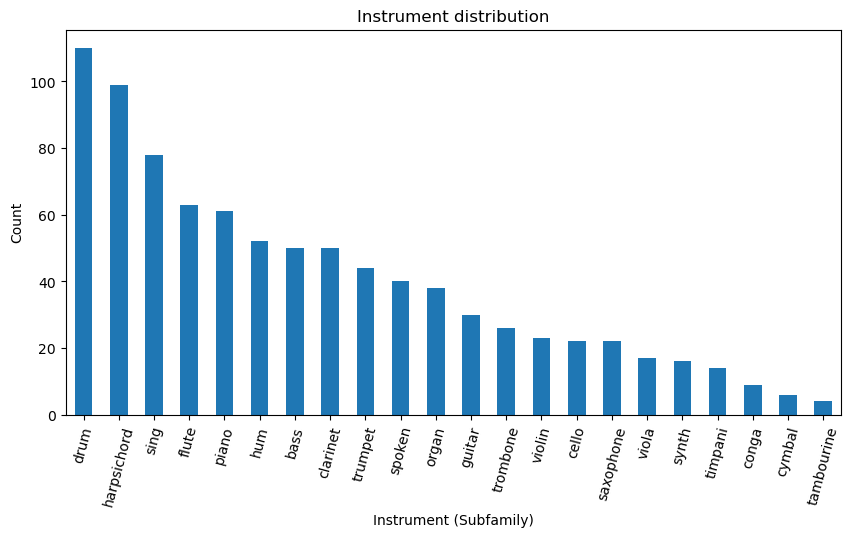

In [13]:
# --- Family & Subfamily (Instrument) Distribution Summary ---

print("🎯 Data distribution by Family and Subfamily (Instrument)\n")

# Counts per family
family_counts = df[FAMILY_COLNAME].value_counts().sort_index()
print("Family counts:")
display(family_counts.rename("count").to_frame())

# Counts per (family, instrument) pair
if "instrument" in df.columns:
    subfamily_counts = (
        df.groupby([FAMILY_COLNAME, "instrument"])
          .size()
          .rename("count")
          .reset_index()
          .sort_values(["count"], ascending=False)
    )
    print("\nSubfamily (Family + Instrument) counts:")
    display(subfamily_counts)
else:
    print("\n⚠️ Column 'instrument' not found — skipping subfamily summary.")

# Optional: visualize imbalance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
family_counts.plot(kind="bar", title="Family distribution", rot=45)
plt.xlabel("Family")
plt.ylabel("Count")
plt.show()

if "instrument" in df.columns:
    plt.figure(figsize=(10, 5))
    df.groupby("instrument").size().sort_values(ascending=False).plot(
        kind="bar", title="Instrument distribution", rot=75
    )
    plt.xlabel("Instrument (Subfamily)")
    plt.ylabel("Count")
    plt.show()
